# PIPR model with numeric input
En este notebook se desarrolla una implementación inspirada en la arquitectura PIPR (Protein–Protein Interaction Prediction via Residual RCNN). El modelo combina bloques convolucionales residuales con redes neuronales recurrentes tipo LSTM para capturar tanto patrones locales como dependencias de largo alcance en las secuencias proteicas. A pesar de su complejidad estructural, esta versión ha sido adaptada a las restricciones computacionales disponibles, y no incluye preprocesamiento estructural adicional.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF="expandable_segments:true"

In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [3]:
max_length = 768 # or 1024

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from protein_dataset import ProteinDataset
from encoders.numeric_protein_encoder import NumericProteinEncoder
from utils import load_numpy_dataset

# Config
device = torch.device("cuda")

batch_size = 64
num_epochs = 10
lr = 1e-3

vocab_size = (NumericProteinEncoder().vocabulary_size() + 1) # +1 for padding token

# Dataset
X1, X2, y = load_numpy_dataset(f"../processed_data/numeric_chunks_{max_length}")
dataset = ProteinDataset(X1, X2, y)
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
from models.pipr_model import PIPRModel

model = PIPRModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
).to(device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [7]:
from tqdm import tqdm
import torch
from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler

scaler = GradScaler()
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    for step, (x1, x2, y) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        optimizer.zero_grad()
        with autocast("cuda"):  # mixed precision
            logits = model(x1, x2)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"---Train loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x1, x2, y in tqdm(val_loader, desc="Validation", leave=False):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            with autocast("cuda"):
                logits = model(x1, x2)
                loss = criterion(logits, y)
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) >= 0.5).long()
            correct += (preds == y.long()).sum().item()
            total += y.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"---Val loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"../models/pipr_model_epochs_{num_epochs}_len_{max_length}_best_model.pth")
        print(f"--Best model saved with val loss {avg_val_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'val_loss': avg_val_loss,
    }, f"../models/pipr_checkpoint_epoch_{epoch + 1}_len{max_length}.pth")

torch.save(model.state_dict(), f"../models/pipr_model_epochs_{num_epochs}_len_{max_length}.pth")


Epoch 1/10


---Train loss: 0.5516


---Val loss: 0.5279 | Accuracy: 0.7382
--Best model saved with val loss 0.5279

Epoch 2/10


---Train loss: 0.4998


---Val loss: 0.5083 | Accuracy: 0.7487
--Best model saved with val loss 0.5083

Epoch 3/10


---Train loss: 0.5436


---Val loss: 0.5510 | Accuracy: 0.7159

Epoch 4/10


---Train loss: 0.5535


---Val loss: 0.5508 | Accuracy: 0.7177

Epoch 5/10


---Train loss: 0.5533


---Val loss: 0.5553 | Accuracy: 0.7142

Epoch 6/10


---Train loss: 0.5689


---Val loss: 0.5807 | Accuracy: 0.6908

Epoch 7/10


---Train loss: 0.5882


---Val loss: 0.5996 | Accuracy: 0.6709

Epoch 8/10


---Train loss: 0.5955


---Val loss: 0.6056 | Accuracy: 0.6694

Epoch 9/10


KeyboardInterrupt: 

In [6]:
# load the best model and evaluate on test set
model.load_state_dict(torch.load(f"../models/pipr_model_epochs_10_len_768_best_model.pth"))
model.eval()

PIPRModel(
  (embedding): Embedding(22, 128, padding_idx=0)
  (projection): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (blocks): Sequential(
    (0): ResidualRCNNBlock(
      (bi_gru): GRU(256, 256, batch_first=True, bidirectional=True)
      (conv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
      (project): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualRCNNBlock(
      (bi_gru): GRU(256, 256, batch_first=True, bidirectional=True)
      (conv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
      (project): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    )
    (2): ResidualRCNNBlock(
      (bi_gru): GRU(256, 256, batch_first=True, bidirectional=True)
      (conv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
      (project): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=1)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Lin

Test Accuracy : 0.7523
Test F1 Score : 0.7422
Test ROC AUC  : 0.8309



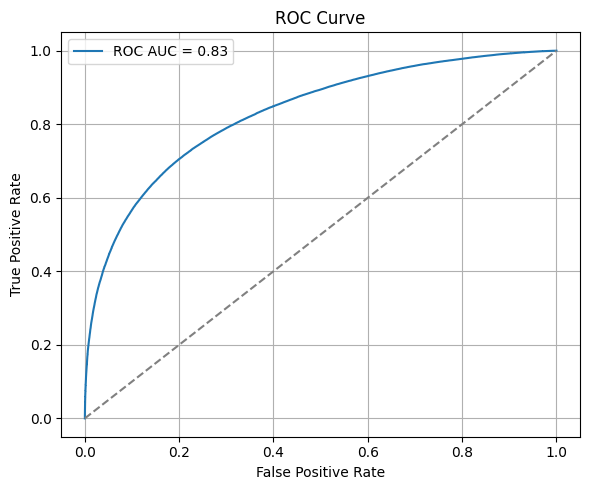

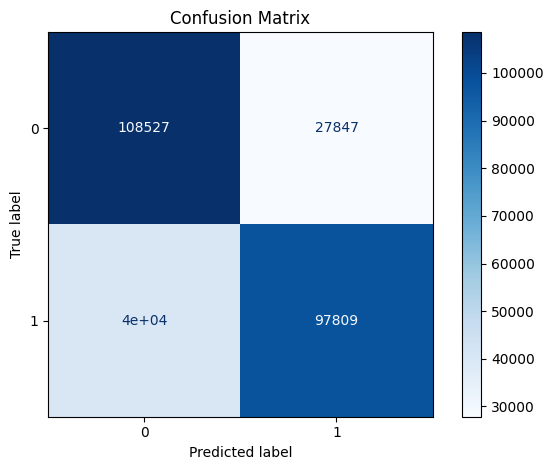

In [7]:
from pipelines import evaluate_model

evaluate_model(model, test_loader, device=device)

Considerando que actualmente:
- Usamos únicamente secuencias de aminoácidos (sin estructuras tridimensionales)
- Que los negativos pueden estar contaminados con falsos negativos (positivos no descubiertos)
- Que el modelo es una implementación original de PIPR simplificada debido a las limitaciones técnicas

Un **75% de accuracy** en test es bastante buena. Significa que el modelo aprende a generalizar a nivel proteoma, está por encima del azar y supera a muchos enfoques clásicos.